In [12]:
# ==========================================
# 1. 라이브러리 및 환경 설정
# ==========================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 실행할 때마다 같은 결과가 나오도록 시드(Seed)를 고정하기
torch.manual_seed(42)
np.random.seed(42)

In [13]:
# ==========================================
# 2. 모델 아키텍처 설계
# ==========================================

# MLP (Multi-Layer Perceptron)
class BatterTypeClassifier(nn.Module):
    def __init__(self):
        super(BatterTypeClassifier, self).__init__()
        self.layer1 = nn.Linear(5, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [14]:
# ==========================================
# 3. 데이터 및 모델 로드
# ==========================================
filename = 'eval_dataset/eval_data.npz'
model_path = 'best_batter_classifier.pth'

# 1) Test Data 로드
try:
    data = np.load(filename)
    X_test = torch.FloatTensor(data['X_test'])
    y_test = torch.LongTensor(data['y_test'])

    print("✅ 데이터 로드 성공!\nTest Dataset: {len(X_test)}개")

except FileNotFoundError:
    print(f"❌ 데이터 로드실패! '{filename}' 파일을 찾을 수 없습니다.")
    raise

# 2) 모델 가중치 로드
model = BatterTypeClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    print("\n✅ 모델 로드 성공!")
    print(f"Model: {model_path}")

except FileNotFoundError:
    print(f"❌ 모델 로드 실패! '{model_path}' 파일을 찾을 수 없습니다.")
    raise

✅ 데이터 로드 성공!
Test Dataset: {len(X_test)}개

✅ 모델 로드 성공!
Model: best_batter_classifier.pth


In [ ]:
# ==========================================
# 4. 모델 평가 및 결과
# ==========================================

X_test = X_test.to(device)
y_test = y_test.to(device)

with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()
y_prob = outputs.cpu().numpy()

# ------------------------------------------
# 1) 타자 유형별 평가 결과
# ------------------------------------------
print("=== 타자 유형별 평가 결과 ===")

target_names = ['GAP', 'POWER', 'CONTACT']
n_classes = len(target_names)

# 타자 유형별 TP, FP, FN 계산
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
support = np.zeros(n_classes)

for i in range(n_classes):
    TP[i] = np.sum((y_true == i) & (y_pred == i))
    FP[i] = np.sum((y_true != i) & (y_pred == i))
    FN[i] = np.sum((y_true == i) & (y_pred != i))
    support[i] = np.sum(y_true == i)

# 타자 유형별 Precision, Recall, F1 계산
precision = np.nan_to_num(TP / (TP + FP))
recall = np.nan_to_num(TP / (TP + FN))
f1 = np.nan_to_num(2 * (precision * recall) / (precision + recall))

header_str = f"{'Batter Type':^12} | {'Support':^9} | {'Precision':^10} | {'Recall':^8} | {'F1':^8}"
sep_len = len(header_str)

print("=" * sep_len)
print(header_str)
print("-" * sep_len)

for i, name in enumerate(target_names):
    print(f"{name:^12} | {int(support[i]):^9} | {precision[i]:^10.4f} | {recall[i]:^8.4f} | {f1[i]:^8.4f}")

print("=" * sep_len)

# ------------------------------------------
# 2) 종합 평가 결과
# ------------------------------------------
print("\n=== 종합 평가 결과 ===")

# Macro Precision, Macro Recall, Macro F1 계산
# 클래스별 지표를 계산한 후 산술 평균
macro_prec = np.mean(precision)
macro_rec = np.mean(recall)
macro_f1 = np.mean(f1)

# Weighted F1 계산
# 클래스별 지표를 계산한 후 가중 평균
total_support = np.sum(support)
weighted_f1 = np.sum(f1 * support) / total_support

# Accuracy 계산
# 최종 예측값이 정답일 확률
total_correct = np.sum(y_true == y_pred)
acc = total_correct / len(y_true)

# Top-2 Accuracy 계산
# 최종 예측값 또는 2순위 예측값이 정답일 확률
top2_correct_count = 0
for i in range(len(y_true)):
    top2_preds = y_prob[i].argsort()[::-1][:2]
    if y_true[i] in top2_preds:
        top2_correct_count += 1
top2_acc = top2_correct_count / len(y_true)

summary_header = f"{'Metric':^17} | {'Result':^12}"
summary_len = len(summary_header)

print("=" * summary_len)
print(summary_header)
print("-" * summary_len)

print(f"{'Macro Precision':^17} | {macro_prec:^10.4f}")
print(f"{'Macro Recall':^17} | {macro_rec:^10.4f}")
print(f"{'Macro F1':^17} | {macro_f1:^10.4f}")
print("-" * summary_len)
print(f"{'Weighted F1':^17} | {weighted_f1:^10.4f}")
print(f"{'Accuracy':^17} | {acc:^10.4f}")
print(f"{'Top-2 Accuracy':^17} | {top2_acc:^10.4f}")
print("=" * summary_len)

=== 타자 유형별 평가 결과 ===
Batter Type  |  Support  | Precision  |  Recall  |    F1   
-----------------------------------------------------------
    GAP      |    23     |   0.8333   |  0.6522  |  0.7317 
   POWER     |     8     |   0.7000   |  0.8750  |  0.7778 
  CONTACT    |     8     |   0.5455   |  0.7500  |  0.6316 

=== 종합 평가 결과 ===
     Metric       |    Result   
--------------------------------
 Macro Precision  |   0.6929  
  Macro Recall    |   0.7591  
    Macro F1      |   0.7137  
--------------------------------
   Weighted F1    |   0.7206  
    Accuracy      |   0.7179  
 Top-2 Accuracy   |   1.0000  


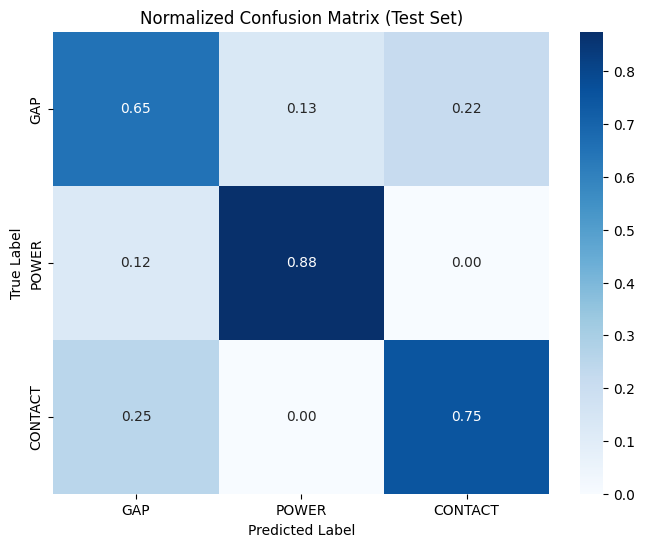

In [16]:
# ==========================================
# 4. 결과 시각화
# ==========================================
cm = np.zeros((n_classes, n_classes))

for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

row_sums = cm.sum(axis=1, keepdims=True)
cm_ratio = np.nan_to_num(cm / row_sums)

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ratio, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Test Set)')
plt.show()